In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 6
rcParams['font.size'] = 12

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

from catboost import CatBoostRegressor

import re

import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from statsmodels import tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import seasonal

from datetime import datetime
#import seaborn as sns
#sns.set()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future

# Data preprocessing

In [3]:
class WindPowerPlant:
    def __init__(self, plant_number):
        self.plant_number = plant_number
    
    def wind_dataset(self):
        dataset = pd.read_csv('windforecasts_wf'+str(self.plant_number)+'.csv')
        dataset['decimal'] = dataset['date']+dataset['hors']
        dataset['decimal'] = dataset['decimal'].apply(lambda x: (int(str(x)[0:4])-2009)*12+\
                                                                  int(str(x)[4:6])+\
                                                                  int(str(x)[6:8])/31+\
                                                                  int(str(x)[8:10])/(24*31))
        dataset['count'] = dataset['hors'].apply(lambda x: (x-1)//12)
        
        wind_speed = dataset.pivot(index='decimal', columns='count', values='ws')
        wind_speed = wind_speed.where(pd.notna(wind_speed), wind_speed.mean(axis=1), axis=0)
        
        wind_direction = dataset.pivot(index='decimal', columns='count', values='wd')
        wind_direction = wind_direction.where(pd.notna(wind_direction), wind_direction.mean(axis=1), axis=0)
        
        output = wind_speed.merge(wind_direction, left_index=True, right_index=True, how='outer',
                                     suffixes=('_speed', '_direction'))
        return output
    
    def power_dataset(self):
        data_gen = pd.read_csv('train.csv')
        data_gen['decimal'] = data_gen['date'].apply(lambda x: (int(str(x)[0:4])-2009)*12+\
                                                                  int(str(x)[4:6])+\
                                                                  int(str(x)[6:8])/31+\
                                                                  int(str(x)[8:10])/(24*31))
        
        data_gen = data_gen.set_index('decimal')
        data_gen['date'] = data_gen['date'].apply(lambda x: str(x)[0:4] + 
                                                              "-" + str(x)[4:6] + 
                                                              "-" + str(x)[6:8] + 
                                                              " " + str(x)[8:10])
        data_gen['date'] = pd.to_datetime(data_gen['date'])
        return data_gen
        
    def merged_dataset(self):
        power = self.power_dataset()
        wind = self.wind_dataset()
        wind['dates'] =  pd.date_range('2010-01-01', periods=37979, freq='60min')
        merged = wind.merge(power.loc[:,['date','wp'+str(self.plant_number)]], 
                            left_index=True, right_index=True, how='outer')
        output = merged.set_index('date')
        return output


In [4]:
wpp_1 = WindPowerPlant(plant_number=3)
data = wpp_1.merged_dataset()
data.drop(data.index[:1], inplace=True)
data = data.set_index('dates')

In [93]:
def test_stationarity(timeseries, window=12):
    r""" Test if provided time series is stationary using visualization and Dickey-Fuller test

    Parameters
    ----------
    timeseries : list
    uniform in time timeseries
    window : int
    size of rolling window
    """ 
  
    # Statistics for rolling mean:
    rolling_mean_series = pd.DataFrame.rolling(timeseries, window=window).mean()
    rolling_std_series = pd.DataFrame.rolling(timeseries, window=window).std()

    # Plot values of statistics:
    plt.plot(timeseries, label='Initial time series')
    plt.plot(rolling_mean_series, label='Rolling mean')
    plt.plot(rolling_std_series, label = 'Rolling standard deviation')
    plt.legend(loc='best')
  
    # Run Dickey-Fuller test for stationarity
    print('Results of Dickey-Fuller test:')
    df_test_values = adfuller(timeseries, autolag='AIC')
    df_test_results = pd.Series(df_test_values[0:4], index=['Statistics', 'p-value', 
                                                          'Length of history', 'Number of observations'])
    for key, value in df_test_values[4].items():
        df_test_results['Critical value (%s)'%key] = value
    print(df_test_results)

In [94]:
data.describe()

,0_speed,1_speed,2_speed,3_speed,0_direction,1_direction,2_direction,3_direction,wp3
count,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000
mean,4.688727,4.641816,4.645091,4.634176,151.188015,153.112492,152.868786,153.237872,0.334609
std,2.319995,2.310135,2.309718,2.303510,96.123711,96.764651,96.407043,96.807805,0.318696
min,0.090000,0.120000,0.050000,0.080000,0.020000,0.040000,0.030000,0.020000,0.000000
25%,2.880000,2.880000,2.880000,2.880000,67.505000,68.532500,68.662500,68.290000,0.069000
50%,4.320000,4.245000,4.240000,4.230000,137.810000,140.150000,140.267500,140.185000,0.217000
75%,6.120000,6.040000,6.030000,6.040000,223.027500,226.271250,225.637500,227.157500,0.563000
max,15.835000,15.835000,16.780000,16.090000,359.980000,359.990000,359.970000,360.000000,0.978000


In [95]:
data2 = data[['0_speed', '0_direction', 'wp3']]
data2.isnull().sum()
A = data2.interpolate()

# Stationarity test

Results of Dickey-Fuller test:
Statistics                -4.741448
p-value                    0.000070
Length of history         11.000000
Number of observations    40.000000
Critical value (1%)       -3.605565
Critical value (5%)       -2.937069
Critical value (10%)      -2.606986
dtype: float64


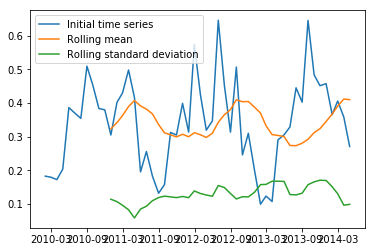

In [96]:
FP = A['wp3'].resample('m').mean()
FP = pd.DataFrame(FP)
test_stationarity(FP['wp3'])

# Making time series stationary

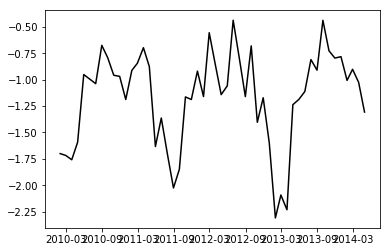

In [97]:
log_data = np.log(FP['wp3'])
plt.plot(log_data, 'k');

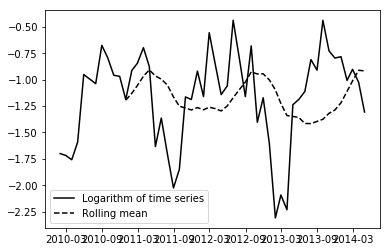

In [115]:
window_size = 12
moving_average = pd.DataFrame.rolling(log_data, window_size).mean()
plt.plot(log_data, 'k', label='Logarithm of time series')
plt.plot(moving_average, 'k--', label='Rolling mean')
plt.legend();

Results of Dickey-Fuller test:
Statistics                -4.041114
p-value                    0.001210
Length of history          5.000000
Number of observations    35.000000
Critical value (1%)       -3.632743
Critical value (5%)       -2.948510
Critical value (10%)      -2.613017
dtype: float64


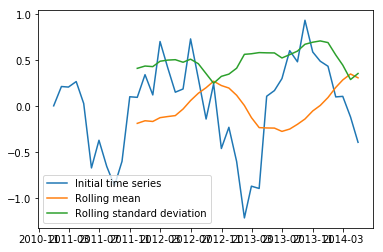

In [116]:
log_data_residuals = log_data - moving_average
log_data_residuals.dropna(inplace=True)
test_stationarity(log_data_residuals)

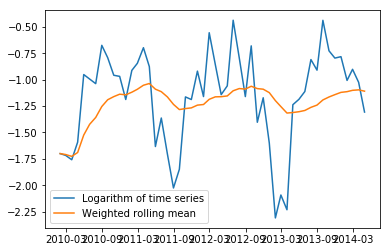

In [117]:
exp_weighted_average = pd.DataFrame.ewm(log_data, halflife=window_size).mean()
plt.plot(log_data, label='Logarithm of time series')
plt.plot(exp_weighted_average, label='Weighted rolling mean')
plt.legend();

Results of Dickey-Fuller test:
Statistics                -3.148669
p-value                    0.023155
Length of history          0.000000
Number of observations    51.000000
Critical value (1%)       -3.565624
Critical value (5%)       -2.920142
Critical value (10%)      -2.598015
dtype: float64


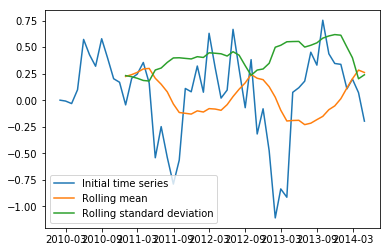

In [118]:
log_data_exp_residuals = log_data - exp_weighted_average
test_stationarity(log_data_exp_residuals)

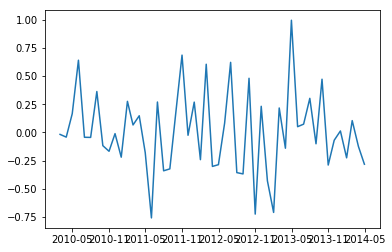

In [102]:
log_data_difference = log_data - log_data.shift()
plt.plot(log_data_difference);

Results of Dickey-Fuller test:
Statistics               -8.470331e+00
p-value                   1.483633e-13
Length of history         0.000000e+00
Number of observations    5.000000e+01
Critical value (1%)      -3.568486e+00
Critical value (5%)      -2.921360e+00
Critical value (10%)     -2.598662e+00
dtype: float64


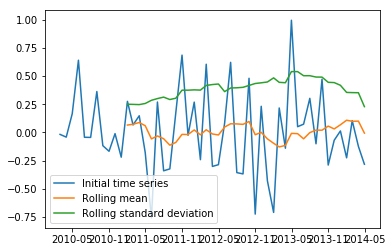

In [103]:
log_data_difference.dropna(inplace=True)
test_stationarity(log_data_difference)

# Split time series to components

We consider three main components iin time series:
* Trend
* Seasonality
* Residuals

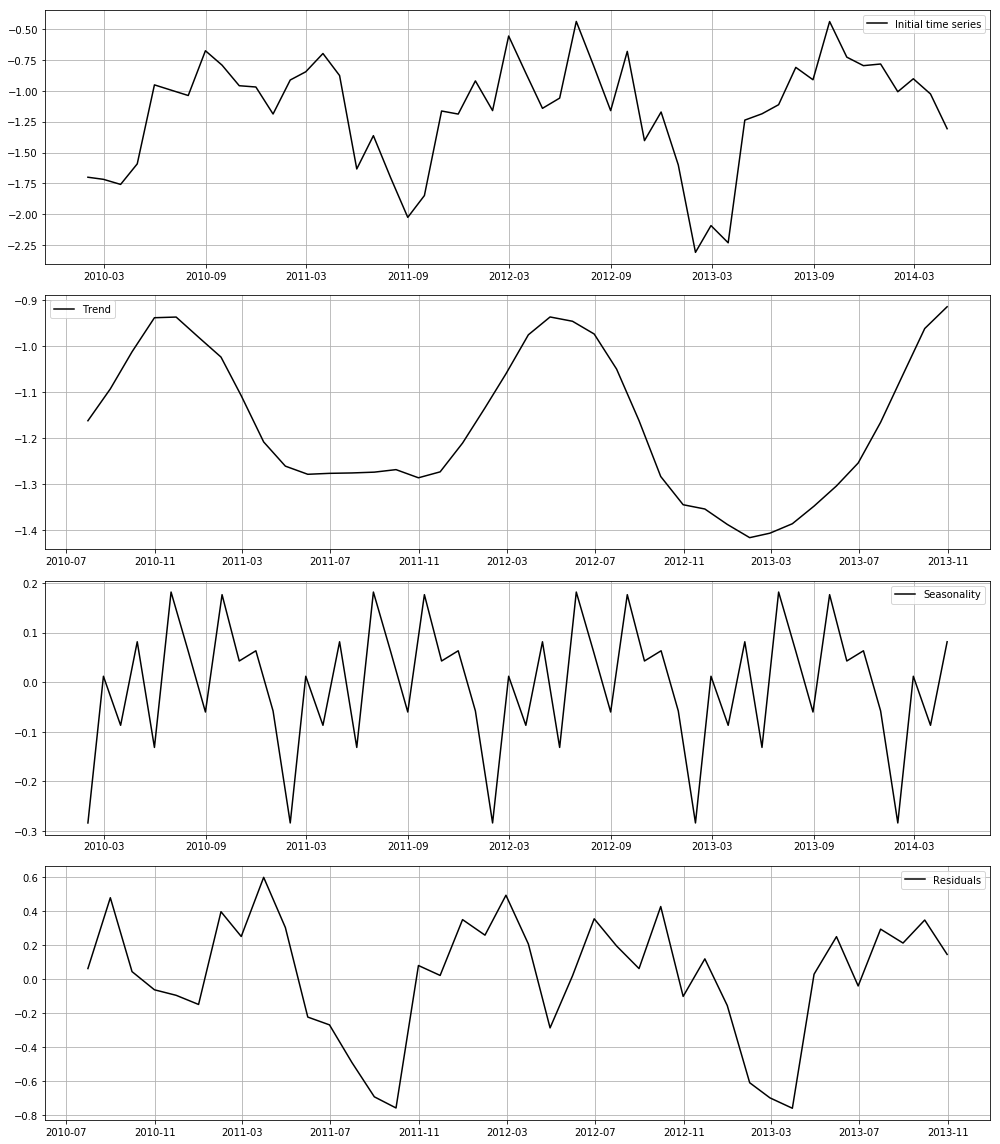

In [119]:
decomposition = seasonal.seasonal_decompose(log_data)

trend_part = decomposition.trend
seasonal_part = decomposition.seasonal
residual_part = decomposition.resid

plt.figure(figsize=(14, 16))
plt.subplot(411)
plt.grid()
plt.plot(log_data, 'k', label='Initial time series')
plt.legend(loc='best')
plt.subplot(412)
plt.grid()
plt.plot(trend_part, 'k', label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.grid()
plt.plot(seasonal_part, 'k', label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_part, 'k', label='Residuals')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()

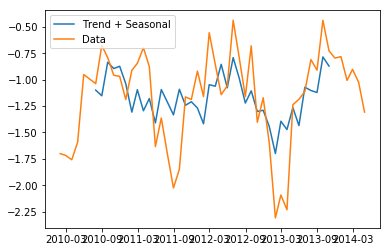

In [120]:
plt.plot(trend_part + seasonal_part, label='Trend + Seasonal')
plt.plot(log_data, label='Data')
plt.legend(loc='upper left')

Results of Dickey-Fuller test:
Statistics                -3.196536
p-value                    0.020186
Length of history          0.000000
Number of observations    39.000000
Critical value (1%)       -3.610400
Critical value (5%)       -2.939109
Critical value (10%)      -2.608063
dtype: float64


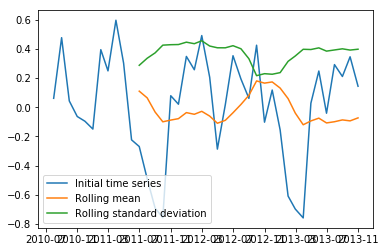

In [106]:
log_data_decomposition = residual_part
log_data_decomposition.dropna(inplace=True)
test_stationarity(log_data_decomposition)

# Discovering autocorrelations

We use two functions: 
* autocorrelation function: correlation with a present value and a past value
* partial autocorrelation function: correlation with a present value and a past value taking into account previous correlations

In [107]:
from statsmodels.tsa.stattools import acf, pacf

In [108]:
lag_autocorrelation_function = tsa.stattools.acf(log_data_difference, nlags=20)
lag_partial_auto_correlation_function = tsa.stattools.pacf(log_data_difference, nlags=20, method='ols')

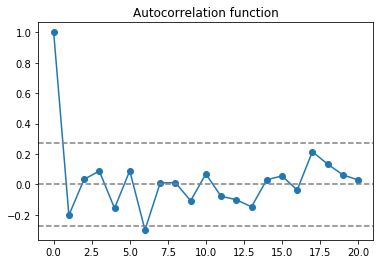

In [109]:
# Autocorrelation function: 
plt.figure()
plt.plot(lag_autocorrelation_function, '-o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(log_data_difference)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(log_data_difference)), linestyle='--', color='gray')
plt.title('Autocorrelation function');

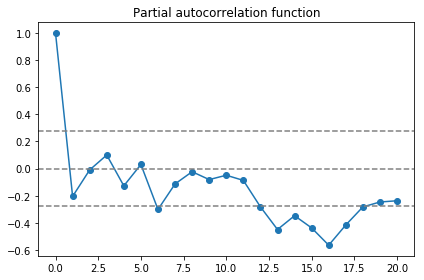

In [110]:
# Partial autocorrelation function:
plt.figure()
plt.plot(lag_partial_auto_correlation_function, '-o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(log_data_difference)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(log_data_difference)), linestyle='--', color='gray')
plt.title('Partial autocorrelation function')
plt.tight_layout()

## ARIMA models

There are two types of terms in ARIMA models:
* AR(IMA) - autoregression
* (ARI)MA - moving average

In [111]:
from statsmodels.tsa.arima_model import ARIMA

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.

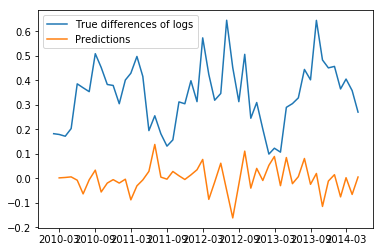

In [123]:
model = ARIMA(FP['wp3'], order=(10, 1, 0))  
results_AR = model.fit(disp=-1)  

plt.plot(FP['wp3'], label='True differences of logs')
plt.plot(results_AR.fittedvalues, label='Predictions')
#plt.title('Mean squared error: %.4f' % mean_squared_error(results_AR.fittedvalues, FP['wp3']));
plt.legend();

### Moving average model MA

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  

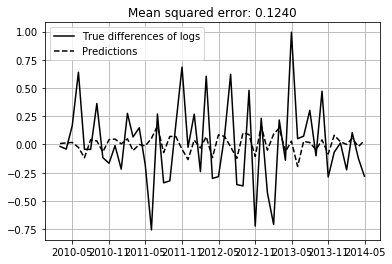

In [113]:
model = ARIMA(log_data, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  

plt.plot(log_data_difference, 'k', label='True differences of logs')
plt.plot(results_MA.fittedvalues, 'k--', label='Predictions')
plt.grid()
plt.title('Mean squared error: %.4f' % mean_squared_error(results_MA.fittedvalues, log_data_difference));
plt.legend();

### Combined ARIMA model

In [162]:
log_data[45:]

dates
2013-10-31   -0.726991
2013-11-30   -0.795927
2013-12-31   -0.782601
2014-01-31   -1.007301
2014-02-28   -0.902279
2014-03-31   -1.025617
2014-04-30   -1.307001
Freq: M, Name: wp3, dtype: float64

In [165]:
results_ARIMA.fittedvalues

dates
2010-01-31   -1.175256
2010-02-28   -1.527255
2010-03-31   -1.543149
2010-04-30   -1.545958
2010-05-31   -1.382173
2010-06-30   -0.968681
2010-07-31   -0.841042
2010-08-31   -0.810045
2010-09-30   -0.769154
2010-10-31   -0.805685
2010-11-30   -0.930191
2010-12-31   -1.063978
2011-01-31   -1.209037
2011-02-28   -1.147317
2011-03-31   -1.147059
2011-04-30   -1.039926
2011-05-31   -1.187546
2011-06-30   -1.501968
2011-07-31   -1.558953
2011-08-31   -1.702145
2011-09-30   -1.684608
2011-10-31   -1.659598
2011-11-30   -1.220767
2011-12-31   -1.065767
2012-01-31   -0.805767
2012-02-29   -0.976181
2012-03-31   -0.693569
2012-04-30   -0.932219
2012-05-31   -0.939360
2012-06-30   -1.193449
2012-07-31   -0.900425
2012-08-31   -1.096937
2012-09-30   -1.177557
2012-10-31   -1.287890
2012-11-30   -1.484937
2012-12-31   -1.467077
2013-01-31   -1.724363
2013-02-28   -1.848935
2013-03-31   -1.879509
2013-04-30   -1.740385
2013-05-31   -1.170786
2013-06-30   -0.956922
2013-07-31   -0.667989
2013-

In [168]:
arima.predict()

TypeError: predict() missing 1 required positional argument: 'params'

In [164]:
arima.predict(log_data[45:])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


array([-0.72699057,  0.89618345, -5.15613597, -0.17555228,  0.92990606,
        3.24979921,  2.04031106,  2.66703554,  1.26875591,  0.86119037,
        0.41364708,  0.38084666,  0.28869404,  0.64137188,  0.6051795 ,
        0.49070601,  0.35372102,  0.52914815,  1.10834335,  1.76436965,
        3.03824251,  4.18360595,  4.15205177,  4.25272054,  3.56307537,
        2.78292938,  1.60352222,  1.06599423,  0.60455697,  0.76640955,
        0.03416086,  0.21740992,  0.16747157,  0.05317149,  0.03322956,
        0.87131771,  1.42092431,  2.47757523,  4.11670866,  4.92638754,
        5.73239188,  5.40508772,  4.52467441,  3.46989544,  1.92321784])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pack

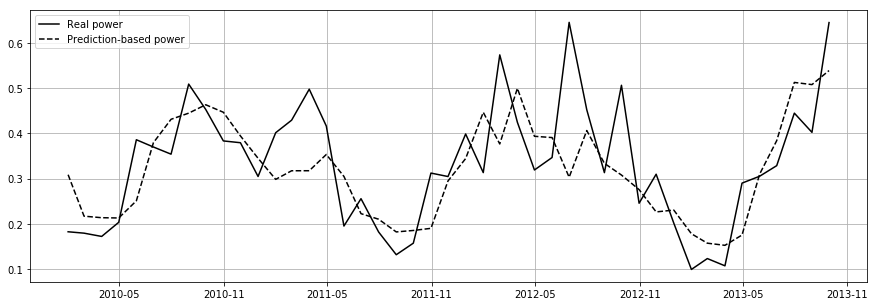

In [160]:
arima = ARIMA(log_data[:45], order=(5, 0, 2))  
results_ARIMA = arima.fit(disp=-1)
plt.figure(figsize=(15,5))
plt.plot(np.exp(log_data[:45]), 'k', label='Real power')
plt.plot(np.exp(results_ARIMA.fittedvalues), 'k--', label='Prediction-based power')
#plt.title('Mean squared error: %.4f' % mean_squared_error(results_ARIMA.fittedvalues, log_data_difference));
plt.grid()
plt.legend();

In [139]:
mean_squared_error(np.exp(results_ARIMA.fittedvalues), np.exp(log_data))

0.008707589307192355

## Usage of machine learning approaches

In [5]:
class ModelGraphics():
    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        
    def wind_curve(self):
        power = self.model.predict(np.linspace(0,13,10000).reshape(-1,1))
        plt.figure(figsize=(6,6))
        plt.plot(np.linspace(0,13,10000), power, 'k')
        plt.title(self.model_name+' Wind Power Curve')
        plt.xlabel('Wind speed, m/s')
        plt.ylabel('Power, p.u.')
        plt.xlim([0,13.5])
        plt.ylim([0,1])
        plt.grid()
        plt.show()
        
    def predict_power(self, x_test, y_test):
        pred = self.model.predict(x_test)
        plt.figure(figsize=(16,6))
        plt.plot(y_test[3285:3309], 'k', label='Real power')
        plt.plot(pred[3285:3309], 'k--', label='Prediction-based power')
        plt.legend()
        plt.title(self.model_name+', MSE='+str(round(mean_squared_error(y_test, pred),6)))
        plt.xlabel('Time, h')
        plt.ylabel('Power, p.u.')
        plt.ylim([0,1])
        #plt.xlim([0,24])
        plt.grid()
        plt.show()

In [6]:
data = data.dropna()

In [15]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.loc[:,['0_speed','0_direction']]),
                                                    np.array(data.loc[:,'wp3']),
                                                    test_size=0.2, shuffle=False)

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [10]:
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

In [13]:
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test = y_scaler.transform(y_test.reshape(-1,1))

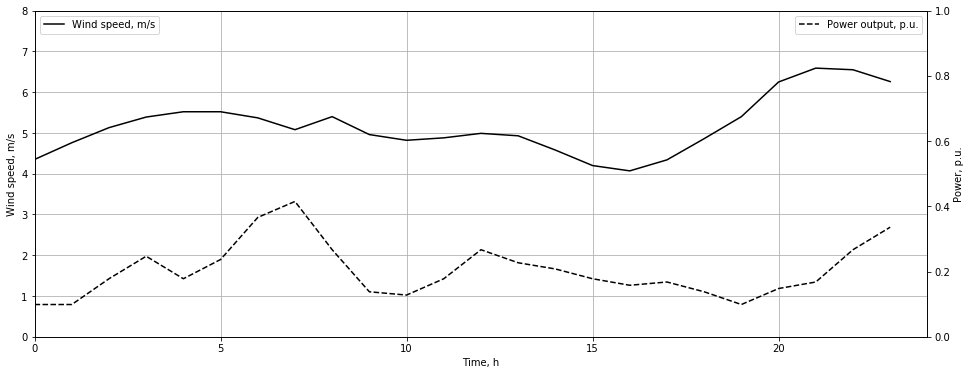

In [59]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(x_train[40:64,0], 'k', label='Wind speed, m/s')

ax2 = ax1.twinx()
ax2.plot(y_train[40:64], 'k--', label='Power output, p.u.')


#ax1.set_title('Dataset sample')
ax1.set_xlabel('Time, h')
ax1.set_ylabel('Wind speed, m/s')
ax2.set_ylabel('Power, p.u.')
ax1.set_xlim([0,24])
ax2.set_ylim([0,1])
ax1.set_ylim([0,8])
ax1.grid()
ax1.legend(loc = 2)
ax2.legend(loc = 1)


In [ ]:
fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('exp', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = np.sin(2 * np.pi * t)
ax2.plot(t, s2, 'r.')
ax2.set_ylabel('sin', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

# CatBoost

In [67]:
cat = CatBoostRegressor()
cat.fit(x_train[:,0].reshape(-1,1), y=y_train, verbose=False)

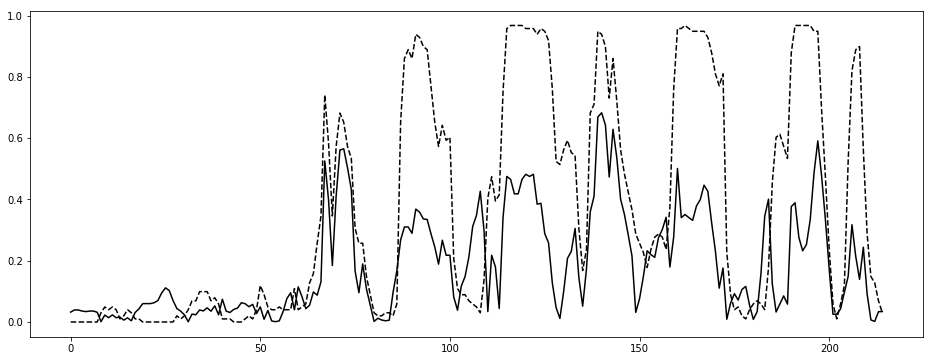

In [70]:
pred = cat.predict(x_test)
plt.figure(figsize=(16,6))
plt.plot(np.abs(y_test[3285:3500]-pred[3285:3500]), 'k', label='Real power')
plt.plot(y_test[3285:3500], 'k--', label='Real power')


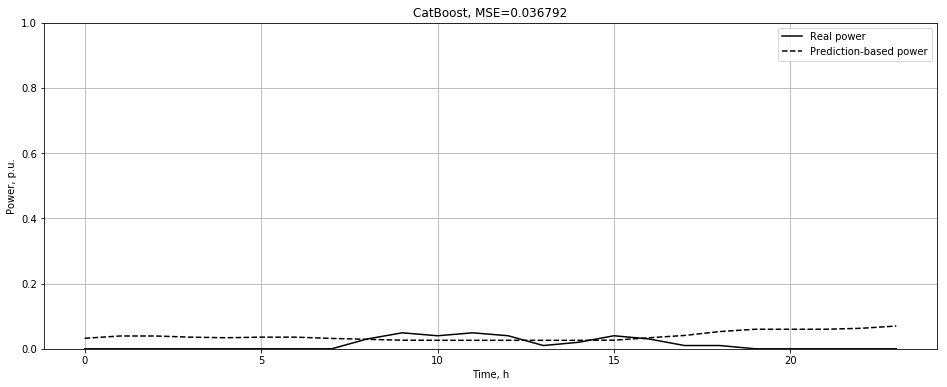

In [71]:
cat_graphics = ModelGraphics(model=cat, model_name='CatBoost')
cat_graphics.predict_power(x_test[:,0].reshape(-1,1), y_test)

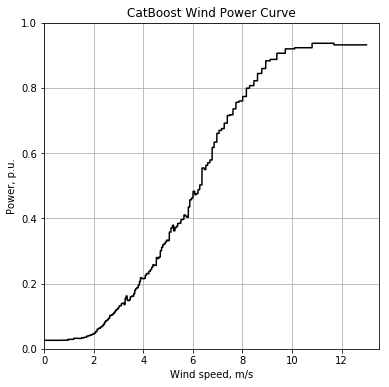

In [72]:
cat_graphics.wind_curve()

# Gaussian Process

In [73]:
gp = GaussianProcessRegressor()

In [74]:
gp.fit(x_train[:15000,0].reshape(-1,1), y_train[:15000])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [75]:
gp_graphics = ModelGraphics(gp,'Gaussian Process')

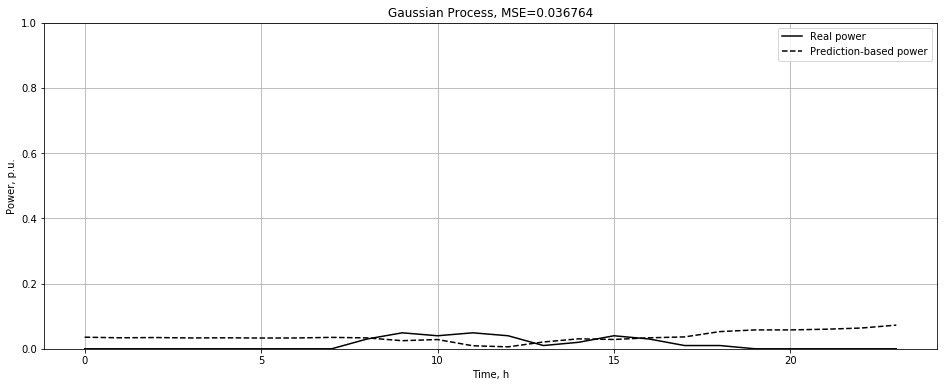

In [76]:
gp_graphics.predict_power(x_test[:,0].reshape(-1,1), y_test)

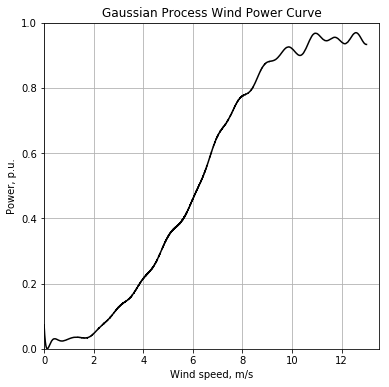

In [77]:
gp_graphics.wind_curve()

# Support Vector Regression

In [83]:
svr = SVR()
params_svr = {'C': np.linspace(1,2,5), 'gamma': np.logspace(-3,3,5),
              'epsilon':np.linspace(0.01,0.5,5), 'kernel':['rbf', 'sigmoid']}
gs_svr = GridSearchCV(svr, param_grid = params_svr, scoring = 'neg_mean_squared_error', n_jobs=-1)
gs_svr.fit(x_train[:1000,0].reshape(-1,1), y_train[:1000])
best_kernel_model = gs_svr.best_estimator_

In [80]:
best_kernel_model = SVR(C=1.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1325,
  gamma=0.03162277660168379, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [81]:
best_kernel_model.fit(x_train[:,0].reshape(-1,1), y_train)

SVR(C=1.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1325,
  gamma=0.03162277660168379, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [82]:
svr_graphics = ModelGraphics(best_kernel_model, 'SVR')

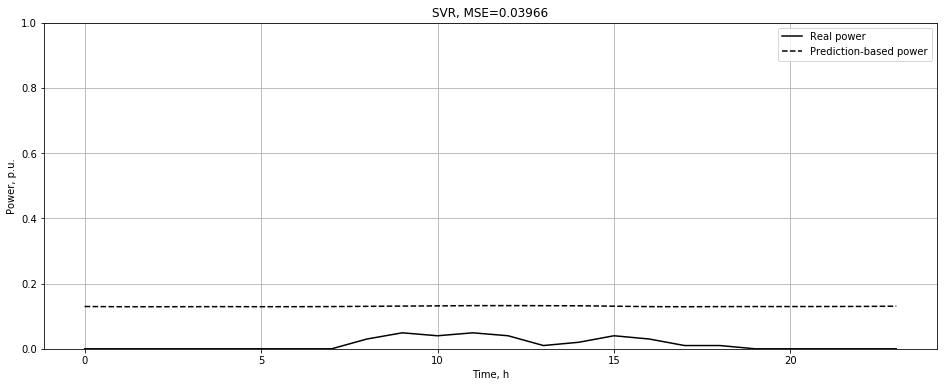

In [83]:
svr_graphics.predict_power(x_test[:,0].reshape(-1,1), y_test)

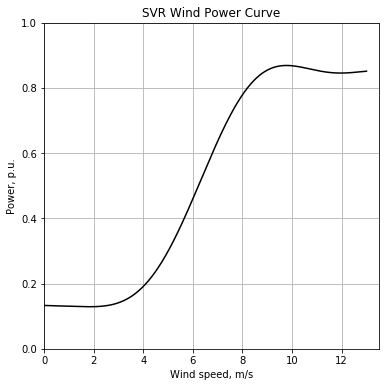

In [84]:
svr_graphics.wind_curve()

# Neural Network

In [85]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [144]:
model = Sequential()
model.add(Dense(2, input_dim=2, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(4, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=40, batch_size=300)

Epoch 1/40
14977/14977 [==============================] - 1s 37us/step - loss: 0.2174
Epoch 2/40
14977/14977 [==============================] - 0s 5us/step - loss: 0.1428
Epoch 3/40
14977/14977 [==============================] - 0s 5us/step - loss: 0.1108
Epoch 4/40
14977/14977 [==============================] - 0s 5us/step - loss: 0.1017
Epoch 5/40
14977/14977 [==============================] - 0s 4us/step - loss: 0.1003
Epoch 6/40
14977/14977 [==============================] - 0s 4us/step - loss: 0.1002
Epoch 7/40
14977/14977 [==============================] - 0s 4us/step - loss: 0.1002
Epoch 8/40
14977/14977 [==============================] - 0s 4us/step - loss: 0.1001
Epoch 9/40
14977/14977 [==============================] - 0s 4us/step - loss: 0.1001
Epoch 10/40
14977/14977 [==============================] - 0s 4us/step - loss: 0.1001
Epoch 11/40
14977/14977 [==============================] - 0s 4us/step - loss: 0.1001
Epoch 12/40
14977/14977 [==============================] - 0s 

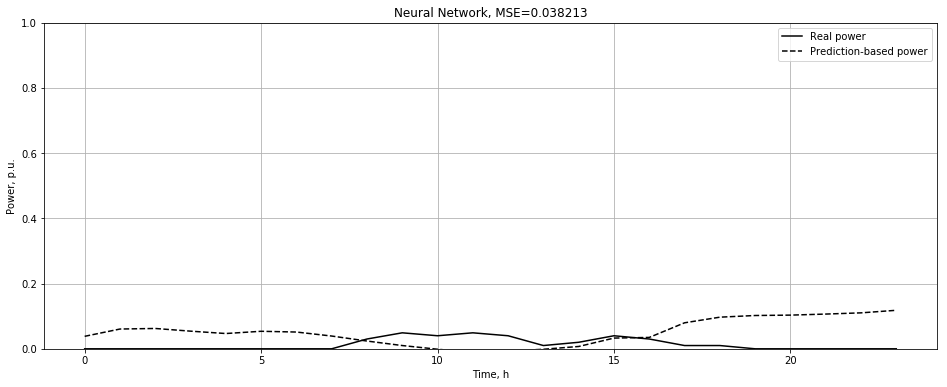

In [145]:
NN = ModelGraphics(model, 'Neural Network')
NN.predict_power(x_test, y_test)

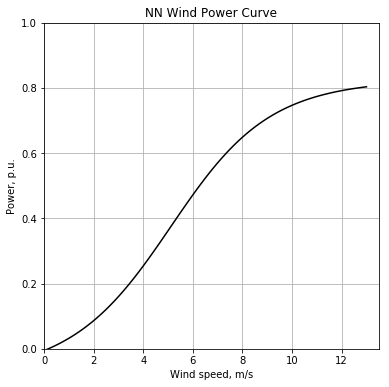

In [146]:
a = np.linspace(0,12,100).reshape(-1,1)
b = np.zeros(a.shape)
curve_nn = np.hstack((a,b))
power = model.predict(curve_nn)
plt.figure(figsize=(6,6))
plt.plot(np.linspace(0,13,100), power, 'k')
plt.title('NN Wind Power Curve')
plt.xlabel('Wind speed, m/s')
plt.ylabel('Power, p.u.')
plt.xlim([0,13.5])
plt.ylim([0,1])
plt.grid()
plt.show()

In [45]:
test_out = cat.predict(x_test)
np.savetxt('testout.csv', test_out, delimiter=',')

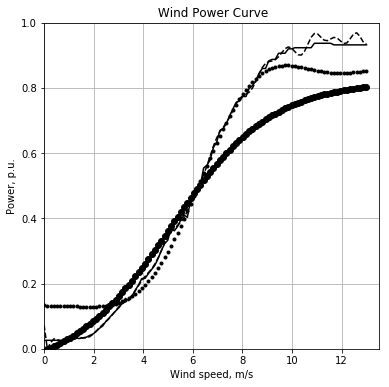

In [155]:
plt.figure(figsize=(6,6))
plt.plot(np.linspace(0,13,100), cat.predict(np.linspace(0,13,100).reshape(-1,1)), 'k')
plt.plot(np.linspace(0,13,100), gp.predict(np.linspace(0,13,100).reshape(-1,1)), 'k--')
plt.plot(np.linspace(0,13,100), best_kernel_model.predict(np.linspace(0,13,100).reshape(-1,1)), 'k.')
plt.plot(np.linspace(0,13,100), model.predict(curve_nn), 'ko')
plt.title(' Wind Power Curve')
plt.xlabel('Wind speed, m/s')
plt.ylabel('Power, p.u.')
plt.xlim([0,13.5])
plt.ylim([0,1])
plt.grid()
plt.show()

## State estimation

In [60]:
from scipy.optimize import minimize
from copy import deepcopy

In [61]:
def lse(x, p_, ws_):
    p = deepcopy(p_)
    ws = deepcopy(ws_)
    a = 0
    n = x_train.shape[0]
    for i in range(n):
        a = a + (p[i]-0.5*1.225/2000000*np.pi*x[0]**2*ws[i]**3*0.5*(116/(x[1]*x[0]/ws[i]) - 0.4*x[2] - 5)*
                 np.exp(-21/(x[1]*x[0]/ws[i])))**2
    return a

In [62]:
x0 = np.array([54, 1.2, 0])

In [63]:
res = minimize(lambda x: lse(x, y_train, x_train[:,0]), x0, 
               method='Nelder-Mead',options={"maxiter": 1000}, tol = 1e-5)

In [66]:
res.x

array([ 43.94846953,   1.52083126, -26.54885536])

In [107]:
p_tuned = np.vectorize(lambda x: 0.5*1.225/2000000*np.pi*res.x[0]**2*x**3
              *0.5*(116/(res.x[1]*res.x[0]/x) - 0.4*res.x[2] - 5)
              *np.exp(-21/(res.x[1]*res.x[0]/x)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


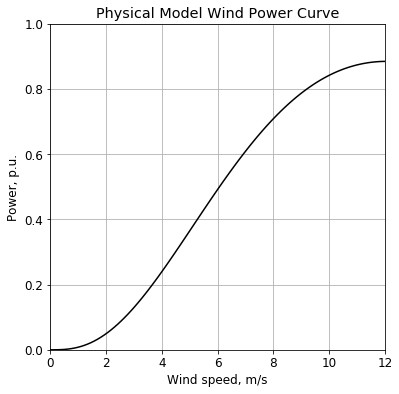

In [116]:
plt.figure(figsize=(6,6))
plt.plot(np.linspace(0,12,100), p_tuned(np.linspace(0,12,100)), 'k')
plt.title('Physical Model Wind Power Curve')
plt.xlabel('Wind speed, m/s')
plt.ylabel('Power, p.u.')
plt.xlim([0,12])
plt.ylim([0,1])
plt.grid()
plt.show()

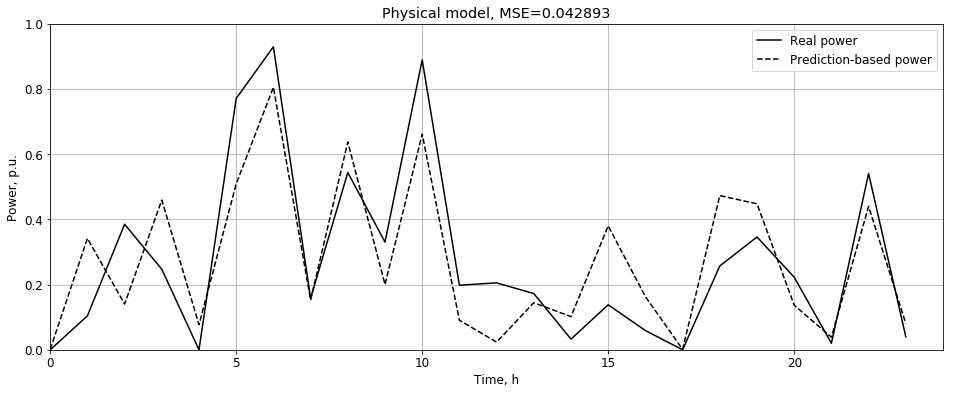

In [118]:
plt.figure(figsize=(16,6))
plt.plot(y_test[:24], 'k', label='Real power')
plt.plot(p_tuned(x_test[:,0])[:24], 'k--', label='Prediction-based power')
plt.legend()
plt.title('Physical model'+', MSE='+str(round(mean_squared_error(y_test, p_tuned(x_test[:,0])),6)))
plt.xlabel('Time, h')
plt.ylabel('Power, p.u.')
plt.ylim([0,1])
plt.xlim([0,24])
plt.grid()
plt.show()